# Future Temperature Velocity (RCP85 Ensemble Average)

In [1]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
import copy
import numba

In [3]:
%matplotlib inline

In [4]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Surface k01

In [5]:
# k01 temperature for ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Temp/RCP85/'
filename = 'temp_k01_ensAvg_1950_2100.nc'
temp_path = directory+filename
ds = xr.open_dataset(temp_path)

## Grid calculations

In [6]:
# default behavior is to extrapolite grid position to the left
ds_full = xgcm.generate_grid_ds(ds, {'X':'xt_ocean', 'Y':'yt_ocean'})

In [7]:
# Create grid object (periodic along X-axis)
grid = xgcm.Grid(ds_full, periodic=['X'], 
                 coords={'X': {'center': 'xt_ocean', 'left': 'xt_ocean_left'},
                         'Y': {'center': 'yt_ocean', 'left': 'yt_ocean_left'},
                         'T': {'center': 'time'}})

In [8]:
# Compute cartesian distances
grid_calculations(grid, ds_full)

---

## Future 2020-2100 Temperature

In [9]:
# Calculate the time-mean temperature for 2020-2100
ds_temp_annual = ds_full.temp.groupby('time.year').mean(dim='time', skipna=True)
ds_temp_mean = ds_temp_annual.sel(year=2020).copy()
for yr in range(2021,2101):
     ds_temp_mean += ds_temp_annual.sel(year=yr)
        
ds_temp_mean = ds_temp_mean/81

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/common.py:671: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  return self._groupby_cls(
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Zonal Gradient of k01 Mean Temperature (ºC / km)

In [10]:
# Compute zonal (along x-axis) gradient of k01 temperature
dtemp_dx = grid.diff(ds_temp_mean, 'X', boundary='fill', fill_value=np.nan) / (ds_full.dxg / 1000)
dtemp_dx = dtemp_dx.squeeze()

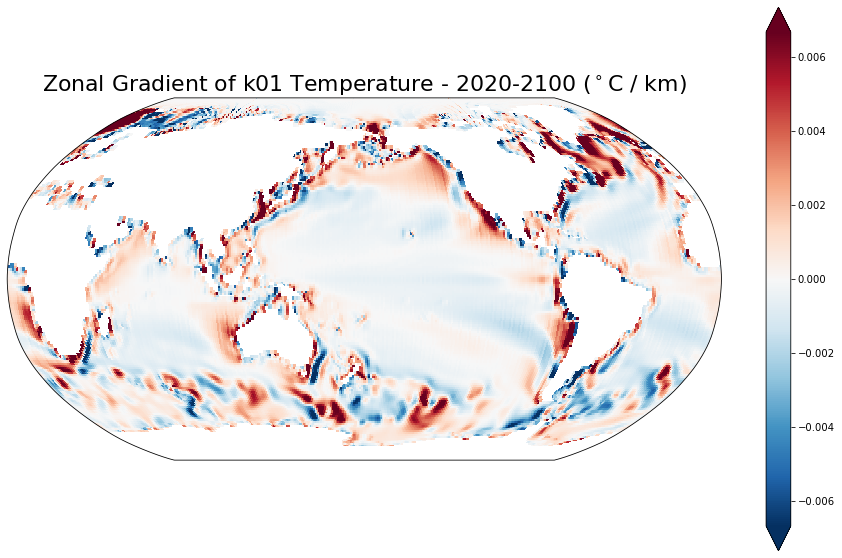

In [11]:
# Plot mean zonal Temperature gradient from 2020-2100
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

dtemp_dx.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Zonal Gradient of k01 Temperature - 2020-2100 ($^\circ$C / km)',
             fontsize=22)
ax.set_global() 
fig.savefig("temp_vel_future")

## Meridional Gradient of k01 Temperature (ºC / km)

In [12]:
# Compute meridional (along y-axis) gradient of surface temperature
dtemp_dy = grid.diff(ds_temp_mean, 'Y', boundary='fill', fill_value=np.nan) / (ds_full.dyg / 1000)
dtemp_dy = dtemp_dy.squeeze()

In [13]:
# Flip direction in southern hemisphere so directions are poleward
dtemp_dy[0:90] = -dtemp_dy[0:90]

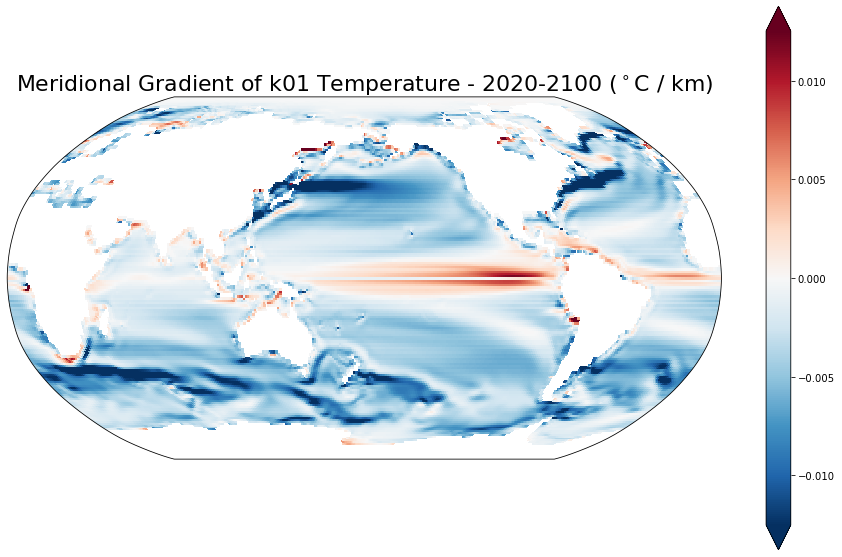

In [14]:
# Plot mean meridional Temperature gradient from 2020-2100
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

dtemp_dy.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Meridional Gradient of k01 Temperature - 2020-2100 ($^\circ$C / km)',
             fontsize=22)
ax.set_global()
fig.savefig("temp_vel_future")

## Gradient Magnitude of k01 Temperature (ºC / km)

In [15]:
# Calculate magnitude of spatial gradient
dx2 = np.square(dtemp_dx).data
dy2 = np.square(dtemp_dy).data
dtemp_ds = np.sqrt(dx2+dy2)
# Create dataset
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data
dtemp_ds = xr.DataArray(dtemp_ds, dims=['yt_ocean','xt_ocean'], coords=[lat,lon])

In [16]:
# Create meshgrid for arrow plotting
X,Y = np.meshgrid(np.arange(360), np.arange(-90,90))
X = X+0.5
Y = Y+0.5
n=5

### Regular Plot

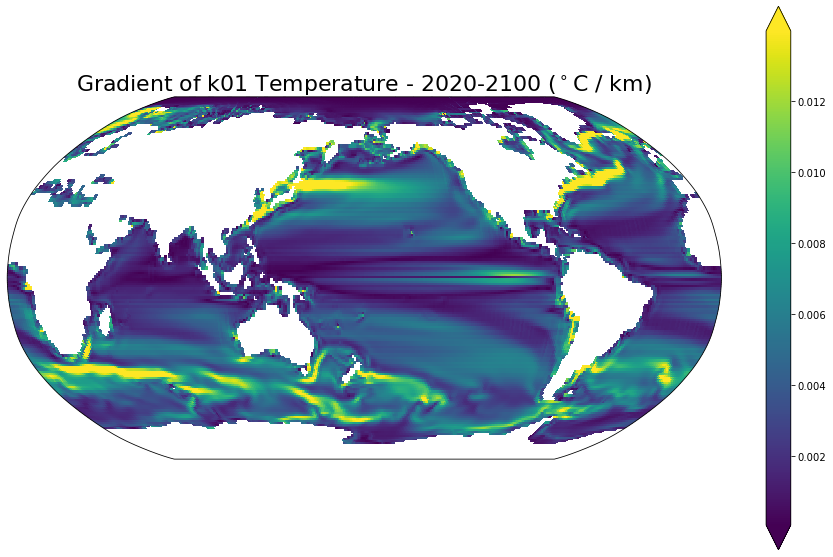

In [17]:
# Plot mean Temperature gradient from 2020-2100
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src=ccrs.PlateCarree()
dtemp_ds.plot(ax=ax, transform=src, robust=True)

ax.set_title('Gradient of k01 Temperature - 2020-2100 ($^\circ$C / km)',
             fontsize=22)

ax.set_global()
fig.savefig("temp_vel_future")

### Latitudinal Mean Spatial Gradient

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


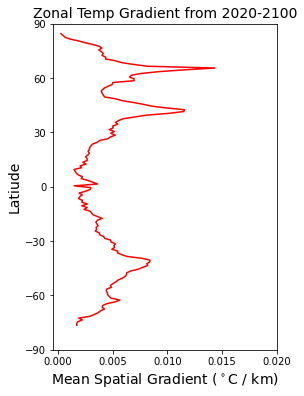

In [18]:
# plot latitudinal mean k01 temperature gradient
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,6])
X = dtemp_ds.mean(dim='xt_ocean', skipna=True).squeeze()[5:175]
Y = dtemp_ds['yt_ocean'][5:175]

ax.plot(X,Y,'r')

ax.set_title('Zonal Temp Gradient from 2020-2100',loc='center',fontsize=14)
ax.set_ylim(-90,90)
# ax.set_xlim(X.min()-0.005, X.max()+0.005)
ax.set_yticks(np.arange(-90,91,30))
ax.set_xticks(np.arange(0,0.021,0.005))
ax.set_ylabel('Latiude',fontsize=14)
ax.set_xlabel('Mean Spatial Gradient ($^\circ$C / km)',fontsize=14)


plt.show()

fig.savefig("temp_vel_stats")

### Contour Plot

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


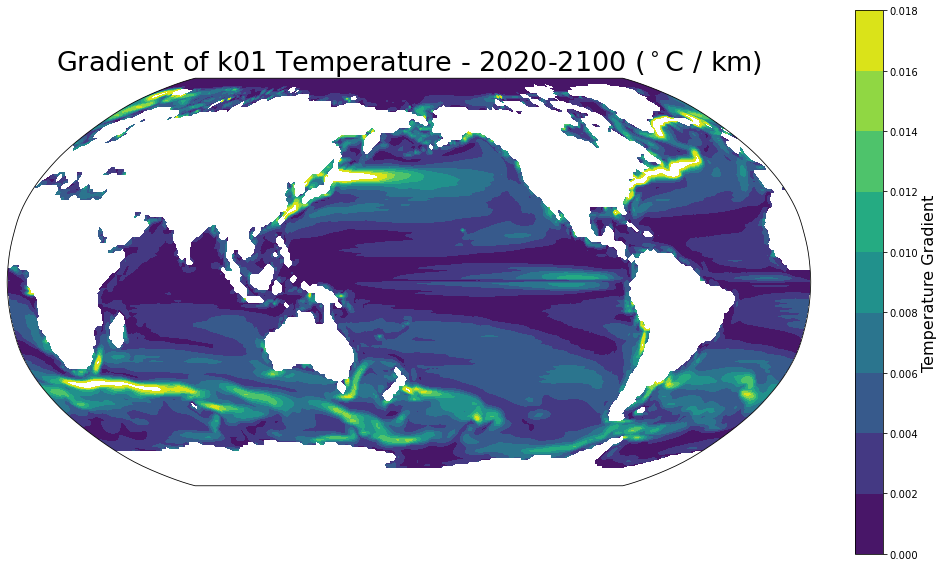

In [19]:
# Plot mean Temperature gradient from 2020-2100 -- Contour Plot
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src = ccrs.PlateCarree()
levels = np.arange(0,0.02,0.002)
im = ax.contourf(lon,lat,dtemp_ds,levels=levels, 
                 transform=src, robust=True)
cbar = plt.colorbar(im,ax=ax,orientation='vertical',fraction=0.05,pad=0.05)
cbar.set_label('Temperature Gradient', fontsize=16)

ax.set_title('Gradient of k01 Temperature - 2020-2100 ($^\circ$C / km)',
             fontsize=27)

ax.set_global()
fig.savefig("temp_vel_future")

---

## k01 Temperature Change

### Decadal Temperature Change from 2020-2100 (ºC / decade)

#### Using Linear Regression (best model)

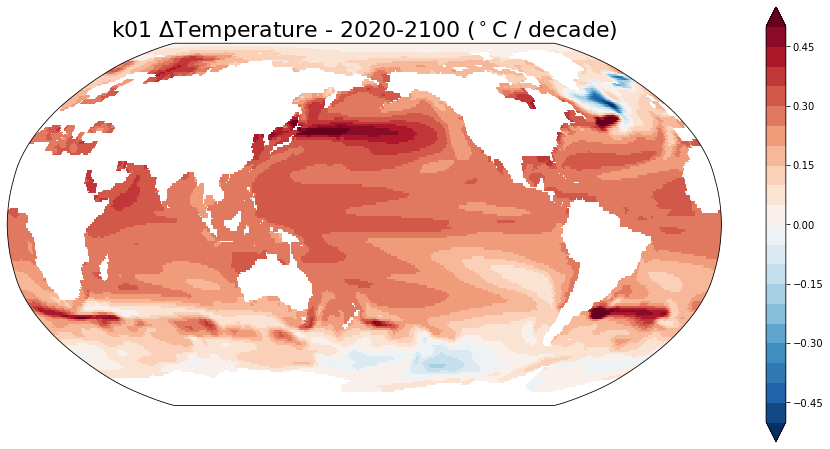

In [20]:
# Plot decadal temperature change using best-fit linear model
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

# Get annual temperature data for 2020-2100
ds_future = ds_temp_annual.loc[2020:2100]

# Get lon, lat and time coordinates
lon = ds_future.xt_ocean.data
lat = ds_future.yt_ocean.data
years = ds_future.year

# For each gridcell, obtain the linear regression for dtemp/dt
# using the annual means over the decade
nx = len(lon)
ny = len(lat)
da_bestfit = np.zeros(shape=(nx,ny))
for x in range(nx):
    for y in range(ny):
        # exclude NaN values
        cell = ds_future.sel(xt_ocean=lon[x], yt_ocean=lat[y])
        idx = np.isfinite(cell).data.squeeze()
        yrs = years[idx].data.tolist()  # years with measured values
        pts = cell[idx].data.tolist()   # gridcells with measured values
        # calculate linear regression for temp (Y) vs. time (X)
        # (if there are at least 2 finite values)
        if sum(idx) > 1:
#             da_bestfit[x,y] = numba_leastsqr(yrs, pts)[0]
            da_bestfit[x,y] = np.polyfit(yrs, pts, 1)[0] * 10
        else:
            da_bestfit[x,y] = np.nan
            
            
# Create DataArray and plot dtemp/dt for the decade
dtemp_dt = xr.DataArray(da_bestfit, dims=['xt_ocean','yt_ocean'], coords=[lon,lat])

levels = np.arange(-0.5,0.51,0.05)
dtemp_dt.T.plot(ax=ax, levels=levels, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 $\Delta$Temperature - 2020-2100 ($^\circ$C / decade)',
            fontsize=22)
ax.set_global()
fig.savefig("temp_vel_future")

### Latitudinal Mean Temp Change

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/matplotlib/colors.py:1442: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= b] = i
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/matplotlib/colors.py:1446: RuntimeWarning: invalid value encountered in less
  iret[xx < self.vmin] = -1
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/matplotlib/colors.py:1447: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= self.vmax] = max_col


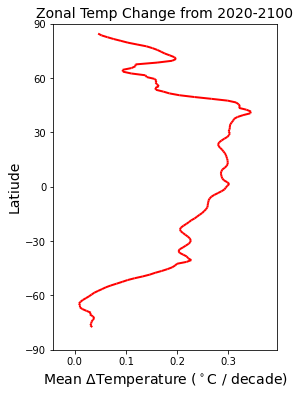

In [21]:
# plot latitudinal mean zonal k01 temperature change at each latitude
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,6])
X = dtemp_dt.mean(dim='xt_ocean', skipna=True).squeeze()[5:175]
Y = dtemp_dt['yt_ocean'][5:175]


# Create a set of line segments to color them individually
points = np.array([X,Y]).T.reshape(-1, 1, 2)  # parameter -1 tells python to find correct dim
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Use a boundary norm to distinguish warming from cooling
cmap = mpl.colors.ListedColormap(['b', 'r'])
norm = mpl.colors.BoundaryNorm([-1, 0, 1], cmap.N)
lc = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(X)
lc.set_linewidth(2)
line = ax.add_collection(lc)


ax.set_title('Zonal Temp Change from 2020-2100',loc='center',fontsize=14)
# ax.autoscale(enable=True, axis='y', tight=True) # Make x-axis "tight"
ax.set_ylim(-90,90)
ax.set_xlim(-0.5, 0.35)
ax.set_yticks(np.arange(-90,91,30))
ax.set_xticks(np.arange(0,0.40,0.1))
ax.set_ylabel('Latiude',fontsize=14)
ax.set_xlabel('Mean $\Delta$Temperature ($^\circ$C / decade)',fontsize=14)


plt.show()

fig.savefig("temp_vel_stats")

---

## Zonal k01 Temperature Velocity (km/decade)

In [ ]:
# Calculate zonal temperature velocity
# Using linear regression over 2020-2100 for temperature change over time,
# and time-mean decadal temperature for spatial gradient
dT_dt = dtemp_dt.squeeze().data
dT_dx = dtemp_dx.squeeze().T.data
x_vel = dT_dt/dT_dx

# Create DataArray and plot temperature velocity
x_vel = xr.DataArray(x_vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
x_vel = x_vel.where(x_vel.loc[:,:] < np.inf)

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()
<ipython-input-22-5d10d178879c>:11: RuntimeWarning: divide by zero encountered in true_divide
  x_vel = dT_dt/dT_dx


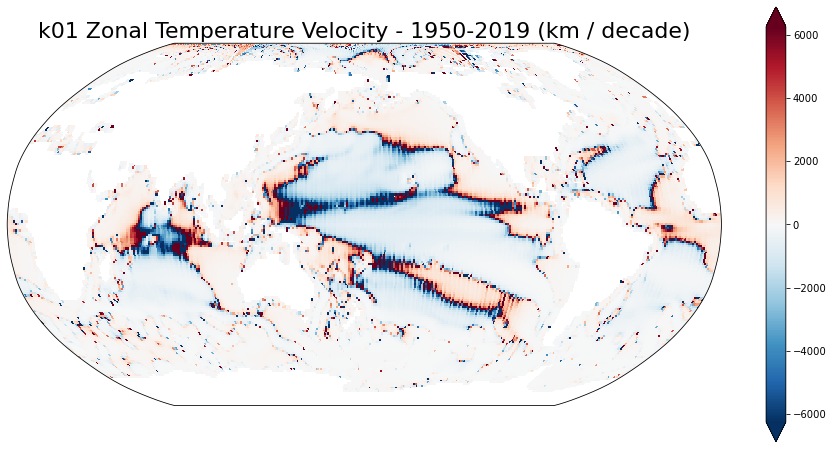

In [22]:
# Plot zonal temperature Velocity (km/decade) from 2020-2100
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

x_vel.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Zonal Temperature Velocity - 1950-2019 (km / decade)',
             fontsize=22)

fig.savefig("temp_vel_future")

## Meridional Temperature Velocity (km/decade)

In [ ]:
# Calculate Meridional temperature velocity
# Using linear regression over 2020-2100 for temperature change over time,
# and time-mean decadal temperature for spatial gradient
dT_dt = dtemp_dt.squeeze().data
dT_dy = dtemp_dy.squeeze().T.data
y_vel = dT_dt/dT_dy

# Create DataArray
y_vel = xr.DataArray(y_vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
y_vel = y_vel.where(y_vel.loc[:,:] != np.inf)

<ipython-input-23-f6c351ac7e8a>:11: RuntimeWarning: divide by zero encountered in true_divide
  y_vel = dT_dt/dT_dy


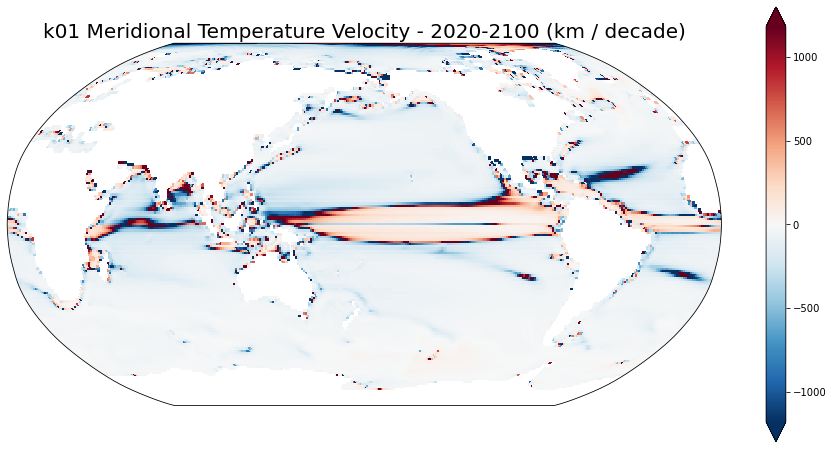

In [23]:
# Plot meridional temperature velocity (km/decade) from 2020-2100
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})


y_vel.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Meridional Temperature Velocity - 2020-2100 (km / decade)',
             fontsize=20)

fig.savefig("temp_vel_future")

## Temperature Velocity (km/decade)

In [24]:
# Calculate the magnitude for temperature velocity 

# Using linear regression over 1950-2019 for temperature change over time,
# and time-mean decadal temperature for spatial gradient
dT_dt = dtemp_dt.squeeze().data
dT_ds = dtemp_ds.squeeze().T.data
velocity = abs(dT_dt/dT_ds)

# Create DataArray
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data

velocity = xr.DataArray(velocity, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
velocity = velocity.where(velocity.loc[:,:] != np.inf)

<ipython-input-24-1073b5144e64>:8: RuntimeWarning: divide by zero encountered in true_divide
  velocity = abs(dT_dt/dT_ds)


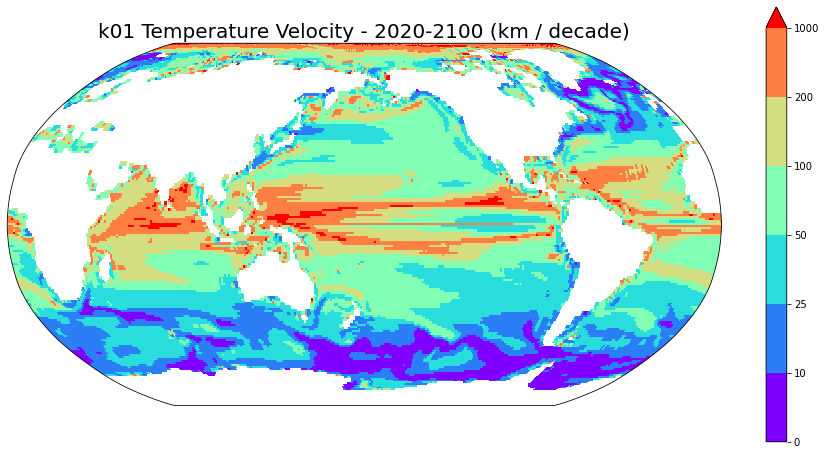

In [25]:
# Plot temperature velocity magnitude (km/decade) from 2020-2100
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

clevs = [0,10,25,50,100,200,1000]
velocity.plot(ax=ax, levels=clevs, cmap='rainbow',transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Temperature Velocity - 2020-2100 (km / decade)',
             fontsize=20)

fig.savefig("temp_vel_future")

### Latitudinal Mean Temp Velocity

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


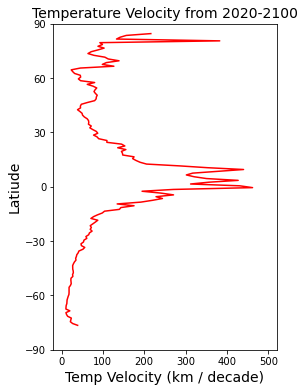

In [27]:
# Plot latitudinal mean k01 temperature velocity
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,6])
X = velocity.mean(dim='xt_ocean', skipna=True).squeeze()[5:175]
Y = velocity['yt_ocean'][5:175]

ax.plot(X,Y,'r')

ax.set_title('Temperature Velocity from 2020-2100',loc='center',fontsize=14)
# ax.autoscale(enable=True, axis='y', tight=True) # Make x-axis "tight"
ax.set_ylim(-90,90)
ax.set_xlim(-20, 520)
ax.set_yticks(np.arange(-90,91,30))
ax.set_ylabel('Latiude',fontsize=14)
ax.set_xlabel('Temp Velocity (km / decade)',fontsize=14)

plt.show()

fig.savefig("temp_vel_stats")